# ViT Implementation of SimClr with Assignment 5 base

Please submit this file to Luminus by **23:59 on 20 Mar**. 

---


1. Finish 2 tasks according to the instructions. Only change the code in the required area and DO NOT change others or add new code/text snippets.
2. Rename this file as "Student_number.ipynb". e.g., 'A0000000J.ipynb'. 

3. Submit the file to /Files/assignments/submission/assignment5. 

Please follow the instructions strictly, otherwise you might be penalized.

If you has any questions, please propose it on Slack, or contact Ziheng Qin (e0823059@u.nus.edu) and Yong Liu (e0672130@u.nus.edu).

First, we import the dataset and define transformation operations on it. We apply random transformation on images (crop + flip + colorjitter + grayscale).

In [ ]:
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10


class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            pos_1 = self.transform(img)
            pos_2 = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return pos_1, pos_2, target


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

Copied over Vision Transformer code in cell below from SiT project


Simple ViT implementation

In [ ]:
# self written ViT code
# referenced from https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

!pip install einops

import torch
from torch import nn
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x



class ViT(nn.Module):
    def __init__(self, *, image_size=256, patch_size=16, num_classes=1000, dim=1024, depth=6, heads=16, mlp_dim=2048, pool = 'cls', channels = 3, dim_head = 64, dropout = 0.1, emb_dropout = 0.1, feature_dim=128):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.linear_crossover = nn.Linear(5120, 2048)


        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), 
                               nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True),
                               nn.Linear(512, feature_dim, bias=True))


        #comment out below
        #self.pool = pool
        #self.to_latent = nn.Identity()
        #self.mlp_head = nn.Sequential(
        #    nn.LayerNorm(dim),
        #    nn.Linear(dim, num_classes)
        #)
        


    def forward(self, x):

        #print("x input shape: ", x.shape)

        x = self.to_patch_embedding(x)

        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        x = self.dropout(x)
        #print("X after dropout layer: ", x.shape)

        x = self.transformer(x)
        #print("X after transformer layer: ", x.shape)

        x = torch.flatten(x,1)
        #print("X after reduce_dim layer: ", x.shape)

        x = self.linear_crossover(x)
        #print("X after linear layer: ", x.shape)

        feature = x
        #print("F after dimension removal: ", feature.shape)

        out = self.g(feature)
        #out = feature
        #print("Out Shape: ", out.shape)


        #comment out below
        #x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        #x = self.to_latent(x)
        #x = self.mlp_head(x)

        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)

        

We use commonly used ResNet-50 as ConvNet encoders for simplicity in the original paper. The task 1 is to set encoder and projection head. The parameters are adapted from the original paper.


Task is to replace the ResNet-50 with a ViT - one for one replacement!

We train encoder network and projection head to maximize agreement using a contrastive loss. The default epoch is 1 for time efficiency while it could takes about 10 minutes to run for one epoch in google colab. The task 2 is to calculate the contrastive loss.
To evaluate the influence of temperature value for contrastive loss, we run this training process 3 times with different temperature value (0.1,0.5 and 1.0).

In [ ]:

import argparse
import os

import pandas as pd
import torch
import torch.optim as optim

!pip install thop
from thop import profile, clever_format
from torch.utils.data import DataLoader
from tqdm import tqdm

#!pip install torchlars
#from torchlars import LARS

import pickle

def contrastive_loss(out_1, out_2, temperature):

    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------
    # Task2: implement contrastive loss function and return loss variable
    # hint: loss formula could refer to the slides
    # input: out_1, out_2，temperature
    # output: loss variable

    out = torch.cat([out_1, out_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
    # [2*B, 2*B-1]
    sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean() 

    # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------

    return loss

# train for one epoch to learn unique features
def train(net, data_loader, train_optimizer, temperature):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for pos_1, pos_2, target in train_bar:
        pos_1, pos_2 = pos_1.cuda(non_blocking=True), pos_2.cuda(non_blocking=True)
        feature_1, out_1 = net(pos_1)
        feature_2, out_2 = net(pos_2)

        loss = contrastive_loss(out_1, out_2, temperature)

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))

    return total_loss / total_num


# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader, temperature):
    net.eval()
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, _, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature, out = net(data.cuda(non_blocking=True))
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, _, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)

            total_num += data.size(0)
            # compute cos similarity between each feature vector and feature bank ---> [B, N]
            sim_matrix = torch.mm(feature, feature_bank)
            # [B, K]
            sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
            # [B, K]
            sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
            sim_weight = (sim_weight / temperature).exp()

            # counts for each class
            one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
            # [B*K, C]
            one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
            # weighted score ---> [B, C]
            pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

            pred_labels = pred_scores.argsort(dim=-1, descending=True)
            total_top1 += torch.sum((pred_labels[:, :1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_top5 += torch.sum((pred_labels[:, :5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'
                                     .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100))

    return total_top1 / total_num * 100, total_top5 / total_num * 100

# Train SimCLR
   
# Feature dim for latent vector, Temperature used in softmax, Top k most similar images used to predict the label
feature_dim, temp, k = 128, [0.1, 0.5, 1], 200
# Number of images in each mini-batch, Number of sweeps over the dataset to train
batch_size, epochs = 128, 501
#batch_size, epochs = 64, 501
# data prepare
#train
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)
#val
memory_data = CIFAR10Pair(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
#test
test_data = CIFAR10Pair(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)


import torch
torch.cuda.is_available()
file_saveinfo=open('simclr_ViT_500.txt','w')



# training loop
temp0=temp[0]

# model setup and optimizer config
#model = Model(feature_dim).cuda()
model = ViT().cuda()

#SOURAV COMMENTED OUT 
#flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
#flops, params = clever_format([flops, params])
#print('# Model Params: {} FLOPs: {}'.format(params, flops))

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
#base_optimizer=optim.Adam(model.parameters(),lr=1e-3/torch.pow(torch.tensor(2.0),0.5*((batch_size/128)-1)), weight_decay=1e-6)
#optimizer=LARS(optimizer=base_optimizer, eps=1e-8, trust_coef=0.001)
c = len(memory_data.classes)

results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': []}
save_name_pre = '{}_{}_{}_{}_{}'.format(feature_dim, temp0, k, batch_size, epochs)
if not os.path.exists('results'):
    os.mkdir('results')
best_acc = 0.0

train_loss_epoch=torch.zeros(epochs)
test_acc_1_epoch=torch.zeros(epochs)
test_acc_5_epoch=torch.zeros(epochs)
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer, temp0)
    train_loss_epoch[epoch-1]=train_loss
        
    results['train_loss'].append(train_loss)
    test_acc_1, test_acc_5 = test(model, memory_loader, test_loader, temp0)
    results['test_acc@1'].append(test_acc_1)
    results['test_acc@5'].append(test_acc_5)
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv('results/{}_statistics.csv'.format(save_name_pre), index_label='epoch')
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        torch.save(model.state_dict(), 'results/{}_model.pth'.format(save_name_pre))
    test_acc_1_epoch[epoch-1]=test_acc_1
    test_acc_5_epoch[epoch-1]=test_acc_5#
    
    file_saveinfo=open('simclr_ViT_500.txt','wb')
    pickle.dump([train_loss_epoch, test_acc_1_epoch, test_acc_5_epoch],file_saveinfo)
    file_saveinfo.close()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Files already downloaded and verified


Test Epoch: [501/501] Acc@1:41.49% Acc@5:87.98%: 100%|██████████| 79/79 [00:08<00:00,  9.73it/s]


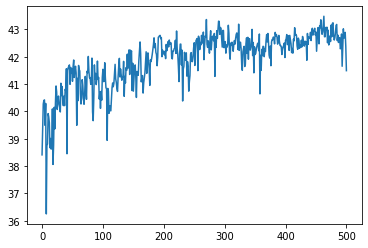

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_acc_1_epoch)

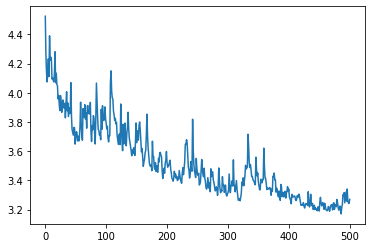

In [ ]:
plt.plot(train_loss_epoch)